In [1]:
import psycopg2
import datetime
import numpy as np
import pandas as pd
from itertools import islice

from sklearn import preprocessing
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

from finance.utilities import utils
from finance.data_science.utilities import financial_utils, time_series_utils, cluster_utils, random_forest_utils

### Get stock data

In [2]:
query = """
    with 
    tickers as (
    select distinct 
        ticker
        , sector
        , industry
    from nasdaq.listed_stocks
    where ticker in ('T', 'BA', 'MMM', 'GA', 'GM', 'GE', 'AAPL', 'MSFT', 'DOW', 'AXP', 'IBM', 'JPM')
    ),
    raw as (
        select 
            market_datetime
            , symbol
            , sector
            , industry
            , (open + close) / 2 as average_price_today
            , volume
            , avg(open) over (partition by symbol order by market_datetime rows between 100 preceding and current row) as average_open_hundred_days
            , avg(open) over (partition by symbol order by market_datetime rows between 50 preceding and current row) as average_open_fifty_days
            , avg(open) over (partition by symbol order by market_datetime rows between 10 preceding and current row) as average_open_ten_days
            , max(open) over (partition by symbol order by market_datetime rows between 100 preceding and current row) as high_open_hundred_days
            , min(open) over (partition by symbol order by market_datetime rows between 100 preceding and current row) as low_open_hundred_days
            , avg(volume) over (partition by symbol order by market_datetime rows between 100 preceding and current row) as average_volume_hundred_days
            , avg(volume) over (partition by symbol order by market_datetime rows between 10 preceding and current row) as average_volume_ten_days
            , avg(open - close) over (partition by symbol order by market_datetime rows between 10 preceding and current row) as average_daily_finish_ten_days
            , avg(high - low) over (partition by symbol order by market_datetime rows between 10 preceding and current row) as average_daily_range_ten_days
            --, lead(open, 10) over (partition by symbol order by market_datetime) as open_ten_days_forward
            , avg(open) over (partition by symbol order by market_datetime rows between 20 following and 29 following) as forward_average
        from td.equities as equities
        inner join tickers
            on tickers.ticker = equities.symbol
        where market_datetime > '2017-01-01'
        )
    select * 
    from raw
    where forward_average is not null
    order by market_datetime
    """

df = utils.query_db(query=query)
df.head()

,market_datetime,symbol,sector,industry,average_price_today,volume,average_open_hundred_days,average_open_fifty_days,average_open_ten_days,high_open_hundred_days,low_open_hundred_days,average_volume_hundred_days,average_volume_ten_days,average_daily_finish_ten_days,average_daily_range_ten_days,forward_average
0,2017-01-03 06:00:00,AXP,Finance,Finance: Consumer Services,75.120,5853881.0,74.89,74.89,74.89,74.89,74.89,5853881.0,5853881.0,-0.46,1.01,77.776
1,2017-01-03 06:00:00,T,Public Utilities,Telecommunications Equipment,42.855,26006613.0,42.69,42.69,42.69,42.69,42.69,26006613.0,26006613.0,-0.33,0.51,41.311
2,2017-01-03 06:00:00,MMM,Health Care,Medical/Dental Instruments,178.440,2510055.0,178.83,178.83,178.83,178.83,178.83,2510055.0,2510055.0,0.78,2.78,176.503
3,2017-01-03 06:00:00,JPM,Finance,Major Banks,87.285,20550714.0,87.34,87.34,87.34,87.34,87.34,20550714.0,20550714.0,0.11,1.78,86.582
4,2017-01-03 06:00:00,BA,Capital Goods,Aerospace,156.635,3426113.0,156.30,156.30,156.30,156.30,156.30,3426113.0,3426113.0,-0.67,1.93,164.695


### Explore data

In [3]:
df['market_datetime_int'] = df['market_datetime'].astype(int)
df['percent_diff'] = (df['forward_average']-df['average_price_today'])/df['average_price_today']

df = cluster_utils.encode_one_hot(df, ['symbol', 'sector', 'industry'])

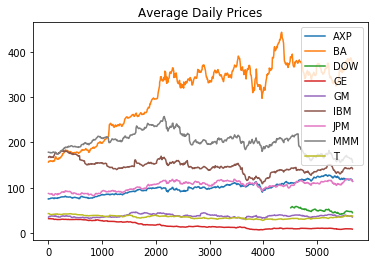

In [4]:
cluster_utils.groupby_plot(df=df, 
                           groupby='symbol', 
                           column='average_price_today', 
                           title='Average Daily Prices')

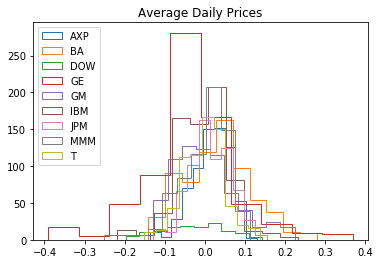

In [5]:
cluster_utils.groupby_plot(df=df, 
                           groupby='symbol', 
                           column='percent_diff', 
                           title='Average Daily Prices',
                           plot_type='histogram')

### Build random forest

#### Target: Open Price 10 Days from Now

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


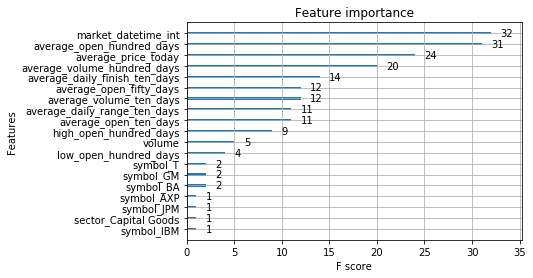

In [6]:
temp = df.copy()

y = temp.groupby('symbol')['percent_diff'].shift(-1)

x = temp[~y.isna()].reset_index(drop=True)
y = y[~y.isna()].reset_index(drop=True)

split = .8
cutoff = int(len(x) * .8)

train_x = x.iloc[:cutoff]
test_x = x.iloc[cutoff:]

train_y = y.iloc[:cutoff]
test_y = y.iloc[cutoff:]

cols_to_ignore = ['symbol', 'sector', 'industry', 'market_datetime', 'forward_average', 'percent_diff']

boost = random_forest_utils.XGBooster(train_x=train_x, 
                                      train_y=train_y,
                                      test_x=test_x,
                                      test_y=test_y,
                                      objective='reg:squarederror',
                                      max_depth=4,
                                      n_estimators=50,
                                      gamma=.01,
                                      columns_to_ignore=cols_to_ignore
                                     )

boost.fit()
boost.predict()
boost.mse

# boost.plot_prediction(prediction)
# boost.plot_prediction_error(prediction)
boost.plot_importance()

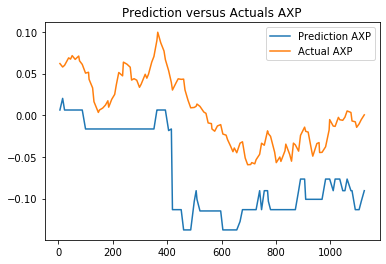

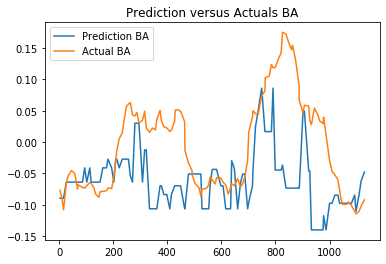

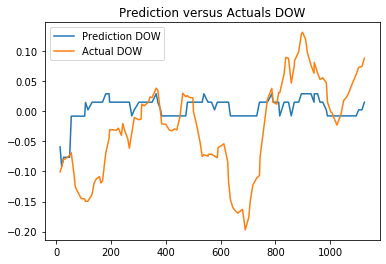

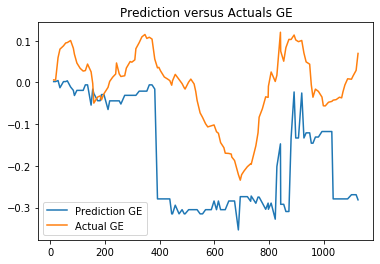

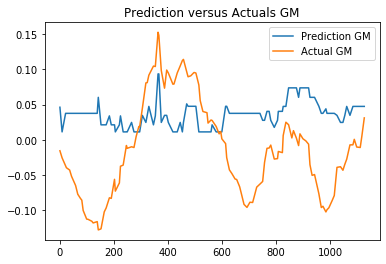

In [7]:
boost.plot_prediction_groupby(groupby='symbol', 
                              title='Prediction versus Actuals', 
                              n_plots=4,
                              n_ticks=10)

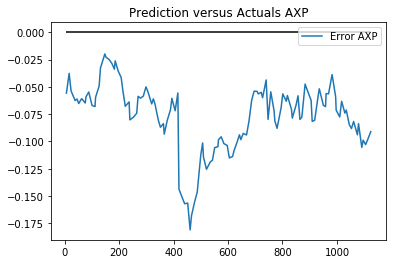

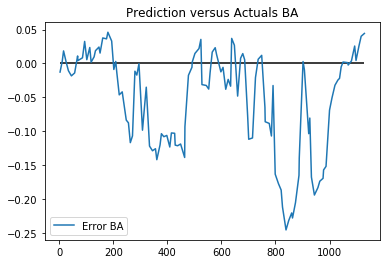

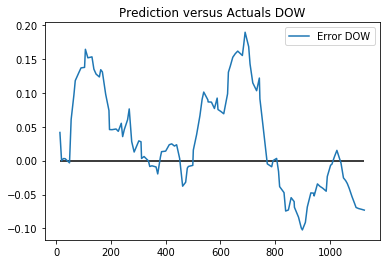

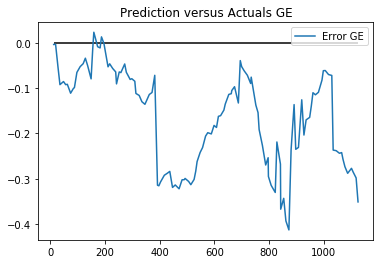

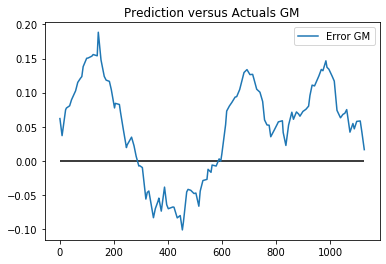

In [8]:
boost.plot_prediction_groupby(groupby='symbol', 
                              title='Prediction versus Actuals', 
                              n_plots=4, 
                              error_plot=True)

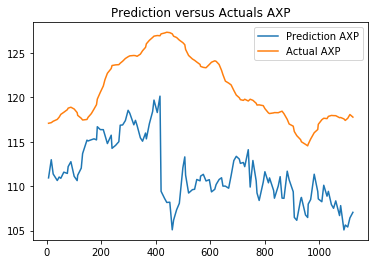

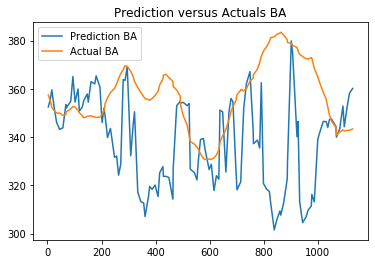

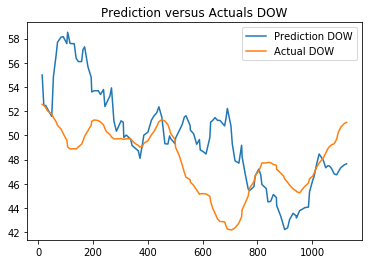

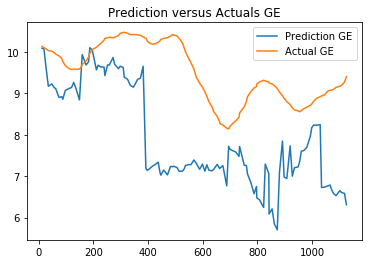

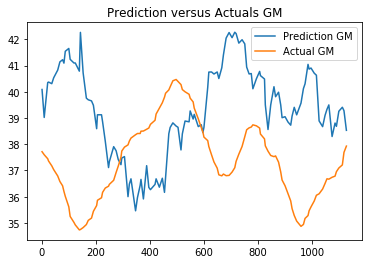

In [9]:
output = boost.output
output['prediction_price'] = (1 + output['prediction']) * output['average_price_today']

boost.plot_prediction_groupby(prediction='prediction_price',
                              actuals='forward_average',
                              groupby='symbol',
                              title='Prediction versus Actuals',
                              n_plots=4,
                              df=output
                             )

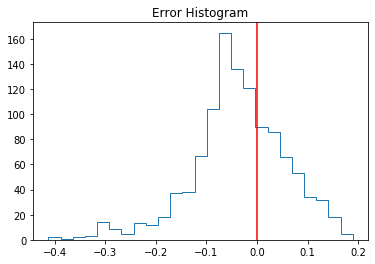

In [20]:
plt.hist(boost.output['prediction']-boost.output['percent_diff'], bins=25, histtype='step')
plt.title('Error Histogram')
plt.axvline(0, color='r')
plt.show()

In [11]:
output.loc[output['symbol']=='GM',
           ['market_datetime', 'average_price_today', 'forward_average', 
            'prediction_price', 'percent_diff', 'prediction']
          ].head(30)

,market_datetime,average_price_today,forward_average,prediction_price,percent_diff,prediction
1,2019-04-03 05:00:00,38.320,37.716,40.087457,-0.015762,0.046124
9,2019-04-04 05:00:00,38.595,37.600,39.022118,-0.025781,0.011067
22,2019-04-05 05:00:00,38.895,37.447,40.351129,-0.037228,0.037437
25,2019-04-08 05:00:00,38.915,37.363,40.371878,-0.039882,0.037437
37,2019-04-09 05:00:00,38.855,37.177,40.309632,-0.043186,0.037437
44,2019-04-10 05:00:00,39.070,37.035,40.532681,-0.052086,0.037437
59,2019-04-11 05:00:00,39.355,36.791,40.828350,-0.065151,0.037437
67,2019-04-12 05:00:00,39.655,36.581,41.139582,-0.077519,0.037437
77,2019-04-15 05:00:00,39.735,36.416,41.222577,-0.083528,0.037437
82,2019-04-16 05:00:00,39.610,36.202,41.092897,-0.086039,0.037437
